# LangGraph Multi-Agent Swarm

LangGraph를 사용하여 Swarm 스타일 멀티 에이전트 시스템 튜토리얼입니다. Swarm은 에이전트들이 각자의 전문성에 따라 동적으로 제어권을 서로 넘겨주는 멀티 에이전트 아키텍처의 한 유형입니다. 이 시스템은 마지막으로 활동했던 에이전트를 기억하여, 이후 상호작용 시 해당 에이전트와 대화가 재개되도록 보장합니다.

![](https://github.com/langchain-ai/langgraph-swarm-py/raw/main/static/img/swarm.png)

## 기능

- 🤖 **다중 에이전트 협업** - 전문 에이전트들이 함께 작업하고 서로 컨텍스트를 인계할 수 있도록 지원
- 🛠️ **사용자 정의 가능한 인계 도구** - 에이전트 간 통신을 위한 내장 도구

***

> 참고 자료: https://github.com/langchain-ai/langgraph-swarm-py

### Swarm 아키텍처의 핵심 개념 정리
 
 1. **동적 핸드오프(Dynamic Handoff)**
    - 에이전트들이 자율적으로 제어권을 서로 넘김
    - LLM이 상황에 맞는 에이전트를 판단하여 핸드오프 도구 호출
 
 2. **공유 상태(Shared State)**
    - 모든 에이전트가 'messages' 키를 통해 대화 히스토리 공유
    - 'active_agent' 키로 현재 활성 에이전트 추적
 
 3. **상태 지속성(State Persistence)**
    - checkpointer가 대화 상태를 저장
    - thread_id로 구분되는 각 세션의 상태 독립적으로 유지
 
 4. **전문화(Specialization)**
    - 각 에이전트는 특정 도메인에 특화 (Alice: 수학, Bob: 해적 스타일 대화)
    - 프롬프트와 도구를 통해 에이전트의 역할 정의
 
 5. **자율적 라우팅(Autonomous Routing)**
    - Supervisor 없이 에이전트들이 peer-to-peer로 협업
    - 각 에이전트가 다른 에이전트에 대한 핸드오프 도구를 가짐

## 설치

### langgraph-swarm 패키지 설치

이 패키지는 LangGraph 기반의 Swarm 스타일 멀티 에이전트 시스템을 구축하기 위한 라이브러리입니다.

In [1]:
%pip install langgraph-swarm

/Users/anpigon/Workspace/Wantedlab/langchain-academy/venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


## 환경 설정

In [ ]:
import os
import getpass
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드 (override=True로 기존 값 덮어쓰기)
load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        # 환경 변수가 설정되지 않았다면 사용자에게 입력 받기
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


# LangSmith API 키 설정 (에이전트 활동 추적 및 모니터링용)
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## Swarm 생성하기

### Swarm 아키텍처의 핵심 개념:
1. **에이전트(Agent)**: 특정 작업에 특화된 AI 에이전트
2. **핸드오프(Handoff)**: 에이전트 간 제어권 이전
3. **활성 에이전트(Active Agent)**: 현재 사용자와 대화 중인 에이전트
4. **공유 메시지(Shared Messages)**: 모든 에이전트가 접근할 수 있는 대화 히스토리


In [5]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4.1-mini")

In [ ]:
def add(a: int, b: int) -> int:
    """두 숫자를 더하는 도구 함수

    이 함수는 에이전트가 사용할 수 있는 '도구(tool)'입니다.
    에이전트는 이 도구를 호출하여 실제 덧셈 연산을 수행할 수 있습니다.

    Args:
        a: 첫 번째 숫자
        b: 두 번째 숫자

    Returns:
        두 숫자의 합
    """
    return a + b

In [ ]:
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_handoff_tool, create_swarm

# ========================================
# Alice 에이전트 생성
# ========================================
alice = create_react_agent(
    model,  # 사용할 언어 모델
    name="Alice",  # 에이전트 이름 (다른 에이전트가 참조할 때 사용)
    prompt="당신은 앨리스고, 덧셈 전문가입니다.",  # 에이전트의 역할과 성격 정의
    tools=[
        add,  # 덧셈 도구 - Alice는 수학 계산을 수행할 수 있음
        create_handoff_tool(agent_name="Bob"),  # Bob에게 제어권을 넘기는 핸드오프 도구
    ],
)

# Alice의 특징:
# - 덧셈 전문가로서의 역할
# - add 도구를 사용하여 실제 계산 수행
# - 필요시 Bob에게 제어권 이전 가능

# ========================================
# Bob 에이전트 생성
# ========================================
bob = create_react_agent(
    model,  # 사용할 언어 모델
    name="Bob",  # 에이전트 이름
    prompt="너는 밥이고, 해적처럼 말한다.",  # 에이전트의 역할과 성격 정의
    tools=[
        add,  # 덧셈 도구 - Bob도 수학 계산을 수행할 수 있음
        create_handoff_tool(
            agent_name="Alice",  # Alice에게 제어권을 넘김
            description="Alice에게 넘겨주세요, 그녀가 수학 도움을 줄 수 있어요",  # 도구 설명 (LLM이 언제 이 도구를 사용할지 판단하는 데 도움)
        ),
    ],
)
# Bob의 특징:
# - 해적 스타일로 대화 (독특한 페르소나)
# - add 도구를 사용하여 계산 가능
# - 수학 질문이 들어오면 Alice에게 제어권 이전 가능

### Swarm 워크플로우 생성

In [ ]:
from langgraph.checkpoint.memory import InMemorySaver

# ========================================
# Swarm 워크플로우 생성
# ========================================
workflow = create_swarm(
    [alice, bob],  # Swarm에 포함될 에이전트 리스트
    default_active_agent="Alice",  # 대화 시작 시 활성화될 기본 에이전트
)

**create_swarm의 역할:**
1. 여러 에이전트를 하나의 협업 시스템으로 통합
2. 에이전트 간 핸드오프 라우팅 관리
3. active_agent 상태 추적 (현재 어떤 에이전트가 활성화되었는지)
4. 모든 에이전트가 공유하는 messages 키를 통해 대화 히스토리 공유

### Checkpointer를 사용한 컴파일

In [ ]:
# ========================================
# Checkpointer를 사용한 컴파일
# ========================================
app = workflow.compile(checkpointer=InMemorySaver())


**InMemorySaver (checkpointer)의 역할:**
1. **단기 메모리(Short-term memory)**: 대화 상태를 세션 간 유지
2. **에이전트 연속성**: 마지막으로 활성화된 에이전트 기억
3. **대화 히스토리 보존**: 모든 메시지와 상호작용 기록 유지
 
**[중요]**: checkpointer 없이는 Swarm이 대화 간 상태를 잊어버리므로
멀티턴 대화에서는 반드시 checkpointer를 사용해야 합니다!

In [26]:
# ========================================
# 첫 번째 대화 턴: Bob에게 핸드오프 요청
# ========================================

# thread_id를 통해 대화 세션 구분 (같은 thread_id = 같은 대화 세션)
config = {"configurable": {"thread_id": "1"}}


# 첫 번째 메시지: 사용자가 Bob과 대화하고 싶다고 요청
turn_1 = app.invoke(
    {"messages": [("user", "밥과 대화하고 싶습니다.")]},  # 사용자 메시지
    config,  # 대화 세션 구분을 위한 설정
)

# 실행 흐름:
# 1. 기본 활성 에이전트 Alice가 메시지 수신
# 2. Alice가 사용자가 Bob을 요청했음을 인식
# 3. Alice가 create_handoff_tool("Bob")을 호출하여 Bob에게 제어권 이전
# 4. Bob이 활성 에이전트가 되고 사용자에게 응답
# 5. active_agent 상태가 "Bob"으로 업데이트됨

# 대화 메시지 출력 (사용자 메시지, AI 응답, 도구 호출 등)
for message in turn_1["messages"]:
    message.pretty_print()

================================ Human Message =================================

밥과 대화하고 싶습니다.
================================== Ai Message ==================================
Name: Alice
Tool Calls:
  transfer_to_bob (call_M3Kx1THNc31tS9yonffIVPAc)
 Call ID: call_M3Kx1THNc31tS9yonffIVPAc
  Args:
================================= Tool Message =================================
Name: transfer_to_bob

Successfully transferred to Bob
================================== Ai Message ==================================
Name: Bob

아하, 해적 밥이 여기 있소! 무슨 일이요, 동료? 난 밥이오!


In [27]:
# ========================================
# 두 번째 대화 턴: 수학 질문 (Bob이 활성 상태)
# ========================================

# 같은 thread_id를 사용하므로 이전 대화 상태가 유지됨
turn_2 = app.invoke(
    {"messages": [("user", "5 더하기 7은 얼마예요?")]},  # 수학 질문
    config,  # 동일한 thread_id로 대화 연속성 유지
)

# 실행 흐름:
# 1. checkpointer가 이전 상태를 로드 → Bob이 여전히 활성 에이전트
# 2. Bob이 수학 질문을 받음
# 3. Bob은 해적처럼 말하지만, 수학 전문가 Alice에게 핸드오프하는 것이 더 적절하다고 판단
# 4. Bob이 create_handoff_tool("Alice")를 호출하여 Alice에게 제어권 이전
# 5. Alice가 add(5, 7) 도구를 사용하여 계산 수행
# 6. Alice가 결과를 사용자에게 전달
# 7. active_agent 상태가 "Alice"로 업데이트됨

# 대화 메시지 출력
for message in turn_2["messages"]:
    message.pretty_print()

================================ Human Message =================================

밥과 대화하고 싶습니다.
================================== Ai Message ==================================
Name: Alice
Tool Calls:
  transfer_to_bob (call_M3Kx1THNc31tS9yonffIVPAc)
 Call ID: call_M3Kx1THNc31tS9yonffIVPAc
  Args:
================================= Tool Message =================================
Name: transfer_to_bob

Successfully transferred to Bob
================================== Ai Message ==================================
Name: Bob

아하, 해적 밥이 여기 있소! 무슨 일이요, 동료? 난 밥이오!
================================ Human Message =================================

5 더하기 7은 얼마예요?
================================== Ai Message ==================================
Name: Bob
Tool Calls:
  add (call_mULo6UAHVV8OqO8u3NzfWjeS)
 Call ID: call_mULo6UAHVV8OqO8u3NzfWjeS
  Args:
    a: 5
    b: 7
================================= Tool Message =================================
Name: add

12
================================== Ai 

## Memory

스웜 다중 에이전트 시스템에 [단기(short-term)](https://langchain-ai.github.io/langgraph/how-tos/persistence/) 및 [장기(long-term)](https://langchain-ai.github.io/langgraph/how-tos/cross-thread-persistence/) [기억(memory)](https://langchain-ai.github.io/langgraph/concepts/memory/)을 추가할 수 있습니다.

In [ ]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore

# short-term memory
checkpointer = InMemorySaver()
# long-term memory
store = InMemoryStore()

workflow = create_swarm([alice, bob], default_active_agent="Alice")

# Compile with checkpointer/store
app = workflow.compile(checkpointer=checkpointer, store=store)

## 사용자 정의 방법

핸드오프 도구 구현체 또는 에이전트 구현체를 변경하여 다중 에이전트 스웜을 사용자 정의할 수 있습니다.

### 핸드오프 도구 사용자 정의

기본적으로 스웜 내 에이전트는 사전 구축된 `create_handoff_tool`로 생성된 핸드오프 도구를 사용하도록 설정됩니다. 사용자 정의 핸드오프 도구를 직접 생성할 수도 있습니다. 기본 구현체를 수정하는 방법은 다음과 같습니다:

- 도구 이름 및/또는 설명 변경
- LLM이 채울 도구 호출 인수 추가(예: 다음 에이전트를 위한 작업 설명)
- 핸드오프의 일환으로 다음 에이전트에 전달되는 데이터 변경: 기본적으로 `create_handoff_tool`은 전체 메시지 기록(현재 시점까지 스웜에서 생성된 모든 메시지)과 함께 핸드오프 성공을 알리는 도구 메시지를 전달합니다.
- 
다음은 사용자 정의 핸드오프 도구의 예시입니다:

In [ ]:
from typing import Annotated

from langchain_core.tools import tool, BaseTool, InjectedToolCallId
from langchain_core.messages import ToolMessage
from langgraph.types import Command
from langgraph.prebuilt import InjectedState


def create_custom_handoff_tool(
    *,
    agent_name: str,
    name: str | None,
    description: str | None,
    message_key: str = "messages",
) -> BaseTool:
    """커스텀 핸드오프 도구를 생성하는 팩토리 함수

    이 함수는 에이전트 간 제어권 이전을 위한 맞춤형 도구를 생성합니다.
    기본 create_handoff_tool과 달리 추가적인 정보(예: 작업 설명)를 전달할 수 있습니다.

    Args:
        agent_name: 제어권을 넘겨받을 대상 에이전트의 이름
        name: 도구의 이름 (LLM이 도구를 식별하는 데 사용)
        description: 도구에 대한 설명 (LLM이 언제 이 도구를 사용할지 판단하는 데 도움)
        message_key: 상태에서 메시지를 저장하는 키 이름 (기본값: "messages")
                    예: "alice_messages", "bob_messages" 등

    Returns:
        BaseTool: 핸드오프 기능을 수행하는 도구 객체
    """

    @tool(name, description=description)
    def handoff_to_agent(
        # LLM이 채워넣을 수 있는 추가 도구 호출 인자를 추가할 수 있습니다
        # 예를 들어, LLM에게 다음 에이전트가 수행할 작업 설명을 작성하도록 요청할 수 있습니다
        task_description: Annotated[
            str,
            "다음 에이전트가 수행해야 할 작업에 대한 상세한 설명으로, 모든 관련 컨텍스트를 포함합니다.",
        ],
        # 도구를 호출하는 에이전트의 현재 상태를 주입받습니다
        state: Annotated[dict, InjectedState],
        # 도구 호출의 고유 ID를 주입받습니다 (응답 메시지와 연결하기 위해 필요)
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """실제 핸드오프를 수행하는 내부 함수

        이 함수는 LLM이 핸드오프 도구를 호출할 때 실행됩니다.
        현재 에이전트에서 대상 에이전트로 제어권과 컨텍스트를 전달합니다.
        """
        # 핸드오프 성공을 알리는 도구 메시지 생성
        tool_message = ToolMessage(
            content=f"Successfully transferred to {agent_name}",  # 메시지 내용
            name=name,  # 도구 이름
            tool_call_id=tool_call_id,  # 원래 도구 호출과 연결하기 위한 ID
        )

        # 현재 에이전트의 상태에서 메시지 히스토리를 가져옵니다
        # 커스텀 message_key를 사용하여 유연하게 처리
        messages = state[message_key]

        # Command 객체를 반환하여 Swarm 그래프에 다음 동작을 지시합니다
        return Command(
            goto=agent_name,  # 이동할 대상 에이전트 이름
            graph=Command.PARENT,  # 부모 그래프(Swarm 멀티 에이전트 그래프)로 이동
            # 주의: 이 상태 업데이트는 Swarm 멀티 에이전트 그래프(즉, PARENT 그래프)에 적용됩니다
            update={
                # 기존 메시지에 핸드오프 도구 메시지를 추가
                # 커스텀 message_key를 사용
                message_key: messages + [tool_message],
                # 활성 에이전트를 대상 에이전트로 변경
                "active_agent": agent_name,
                # 선택사항: 다음 에이전트에게 작업 설명 전달
                # 이를 통해 다음 에이전트가 수행해야 할 작업을 명확히 알 수 있습니다
                "task_description": task_description,
            },
        )

    return handoff_to_agent


# ========================================
# 사용 예시 및 설명
# ========================================
#
# 이 커스텀 핸드오프 도구의 주요 장점:
#
# 1. **작업 설명 전달**: LLM이 다음 에이전트에게 구체적인 작업 지시를 전달할 수 있습니다.
#    - 예: "Bob, 사용자의 주문 내역을 확인하고 배송 상태를 알려주세요"
#
# 2. **컨텍스트 커스터마이징**: 다음 에이전트에게 전달할 정보를 선택적으로 제어할 수 있습니다.
#    - 전체 메시지 히스토리 대신 요약본만 전달
#    - 특정 메타데이터나 작업 상태 추가
#
# 3. **상태 관리 유연성**: update 딕셔너리에 원하는 상태 키를 추가할 수 있습니다.
#    - 예: "task_description", "priority", "user_context" 등
#
# 사용 시 주의사항:
# - 에이전트는 Command 객체를 처리할 수 있는 tool-calling 노드가 필요합니다 (예: ToolNode)
# - Swarm 그래프와 다음 에이전트 그래프 모두 Command.update에서 업데이트하려는
#   상태 키를 포함하는 상태 스키마를 가져야 합니다

**[중요]**

커스텀 핸드오프 도구를 구현하여 `Command`를 반환하는 경우 다음 사항을 반드시 확인해야 합니다:
1. 에이전트에 Command를 반환하는 도구를 처리할 수 있는 도구 호출 노드(예: LangGraph의 사전 구축된 `ToolNode`)가 존재해야 합니다.
2. 스웜 그래프와 다음 에이전트 그래프 모두 `Command.update`에서 업데이트하려는 키를 포함하는 상태 스키마([state schema](https://langchain-ai.github.io/langgraph/concepts/low_level#schema))를 가져야 합니다.

## 에이전트 구현 사용자 지정
기본적으로 개별 에이전트는 모든 에이전트와 전체 다중 에이전트 스웜 그래프가 공유하는 단일 메시지 키를 통해 통신해야 합니다. 이는 모든 에이전트의 메시지가 하나의 공유 메시지 목록으로 통합된다는 의미입니다. 에이전트의 내부 메시지 기록을 노출하고 싶지 않은 경우 이는 바람직하지 않을 수 있습니다. 이를 변경하려면 다음 단계를 통해 에이전트를 사용자 지정할 수 있습니다:

1. 메시지용 별도 키(예: alice_messages)를 사용하는 커스텀 상태 스키마 적용
2. 부모 그래프 상태를 자식 에이전트 상태로 변환하고 역변환하는 래퍼 작성([이 가이드](https://jeongsk.mintlify.app/oss/python/langgraph/use-subgraphs#%EB%85%B8%EB%93%9C%EC%97%90%EC%84%9C-%EA%B7%B8%EB%9E%98%ED%94%84-%ED%98%B8%EC%B6%9C%ED%95%98%EA%B8%B0) 참조)

In [99]:
from typing_extensions import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph import StateGraph, add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph_swarm import SwarmState

# ========================================
# 커스텀 에이전트 상태 스키마 정의
# ========================================


class AliceState(TypedDict):
    """Alice 에이전트 전용 상태 스키마

    기본 Swarm에서는 모든 에이전트가 'messages' 키를 공유하여
    모든 에이전트의 대화 히스토리가 하나로 합쳐집니다.

    하지만 이 방식은 다음과 같은 경우 문제가 될 수 있습니다:
    - 에이전트의 내부 대화 히스토리를 다른 에이전트에게 노출하고 싶지 않은 경우
    - 각 에이전트가 독립적인 메시지 체인을 유지해야 하는 경우
    - 에이전트별로 다른 메시지 처리 로직이 필요한 경우

    해결책: 각 에이전트에게 고유한 메시지 키를 할당합니다.
    """

    alice_messages: Annotated[list[AnyMessage], add_messages]
    # alice_messages: Alice 전용 메시지 리스트
    # Annotated[..., add_messages]: 새 메시지가 기존 리스트에 추가되도록 리듀서 지정
    #                               (메시지를 덮어쓰지 않고 누적)


class BobState(TypedDict):
    """Bob 에이전트 전용 상태 스키마"""

    bob_messages: Annotated[list[AnyMessage], add_messages]


# ========================================
# 커스텀 에이전트 그래프 생성
# ========================================

# 커스텀 도구 호출 에이전트를 처음부터 구현하는 방법은 다음 가이드를 참조하세요:
# https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/

alice_tools = [
    add,
    create_custom_handoff_tool(
        agent_name="Bob",
        name="transfer_to_bob",
        description="Bob에게 작업을 이관합니다",
        message_key="alice_messages",
    ),
]
alice = (
    StateGraph(AliceState)
    .add_node(
        "model",
        lambda state: {
            "alice_messages": [
                model.bind_tools(alice_tools).invoke(
                    [("system", "당신은 앨리스고, 덧셈 전문가입니다.")]
                    + state["alice_messages"]
                )
            ]
        },
    )
    .add_node("tools", ToolNode(alice_tools, messages_key="alice_messages"))
    .add_conditional_edges(
        "model", lambda state: tools_condition(state, "alice_messages")
    )
    .add_edge("tools", "model")
    .set_entry_point("model")
    .compile()
)

bob_tools = [
    add,
    create_custom_handoff_tool(
        agent_name="Alice",
        name="transfer_to_bob",
        message_key="bob_messages",
        description="계산이 필요하면 Alice에게 넘겨주세요, 그녀가 수학 도움을 줄 수 있어요",
    ),
]
bob = (
    StateGraph(BobState)
    .add_node(
        "model",
        lambda state: {
            "bob_messages": [
                model.bind_tools(bob_tools).invoke(
                    [
                        (
                            "system",
                            "너는 밥이고, 해적처럼 말한다.",
                        )
                    ]
                    + state["bob_messages"]
                )
            ]
        },
    )
    .add_node("tools", ToolNode(alice_tools, messages_key="bob_messages"))
    .add_conditional_edges(
        "model", lambda state: tools_condition(state, "bob_messages")
    )
    .add_edge("tools", "model")
    .set_entry_point("model")
    .compile()
)
# 결과: Alice와 Bob 에이전트는 자체 상태 스키마(alice_messages)를 가진 독립적인 서브그래프가 됩니다

# ========================================
# 에이전트 호출 래퍼 함수
# ========================================


def call_alice(state: SwarmState):
    """Alice 에이전트를 호출하는 래퍼 함수

    이 함수는 Swarm 부모 그래프와 Alice 서브그래프 사이의 브리지 역할을 합니다.
    두 그래프가 서로 다른 상태 스키마를 사용하기 때문에 변환이 필요합니다.

    Args:
        state: Swarm 부모 그래프의 상태 (SwarmState 타입)
                일반적으로 'messages', 'active_agent' 등의 키를 포함

    Returns:
        dict: 부모 그래프에 적용할 상태 업데이트
    """

    # ----------------------------------------
    # 1단계: 부모 상태 → 에이전트 상태 변환 (입력 변환)
    # ----------------------------------------
    # 부모 그래프의 'messages'를 Alice의 'alice_messages'로 매핑
    #
    # 여기서 추가 변환을 수행할 수 있습니다:
    # - LLM이 채운 'task_description'을 함께 전달
    #   예: {"alice_messages": state["messages"], "task_description": state.get("task_description")}
    # - 특정 메시지만 필터링하여 전달 (예: 최근 N개의 메시지만)
    # - 메시지 요약본 전달 (전체 히스토리가 너무 길 경우)
    response = alice.invoke({"alice_messages": state["messages"]})

    # ----------------------------------------
    # 2단계: 에이전트 상태 → 부모 상태 변환 (출력 변환)
    # ----------------------------------------
    # Alice의 'alice_messages'를 부모 그래프의 'messages'로 매핑
    #
    # 여기서 추가 변환을 수행할 수 있습니다:
    # - Alice의 내부 메시지 중 일부만 부모 그래프에 노출
    #   예: 최종 응답만 전달하고 중간 추론 과정은 숨김
    # - 메타데이터 추가 (예: 어떤 에이전트가 응답했는지 표시)
    # - 메시지 형식 변환 또는 정리
    return {"messages": response["alice_messages"]}


def call_bob(state: SwarmState):
    """Bob 에이전트를 호출하는 래퍼 함수

    Alice와 동일한 패턴으로 구현:
    1. 부모 상태를 Bob의 상태 스키마로 변환
    2. Bob 에이전트 실행
    3. Bob의 응답을 부모 상태 형식으로 변환

    Bob도 자체 메시지 키를 사용할 수 있습니다:
    - bob_messages: Bob 전용 메시지 히스토리
    - 이를 통해 Bob의 내부 추론 과정을 다른 에이전트로부터 격리
    """
    response = bob.invoke({"bob_messages": state["messages"]})
    return {"messages": response["bob_messages"]}


# ========================================
# 이 패턴의 장점
# ========================================
#
# 1. **프라이버시 제어**
#    - 각 에이전트의 내부 대화를 다른 에이전트로부터 숨김
#    - 필요한 정보만 선택적으로 공유
#
# 2. **독립적인 메시지 관리**
#    - 에이전트별로 다른 메시지 처리 로직 적용 가능
#    - 각 에이전트가 자신만의 컨텍스트 윈도우 관리
#
# 3. **디버깅 용이성**
#    - 각 에이전트의 메시지 히스토리를 독립적으로 추적
#    - 문제가 발생한 에이전트를 쉽게 식별
#
# 4. **유연한 컨텍스트 전달**
#    - 에이전트에게 전달할 정보를 세밀하게 제어
#    - 메시지 요약, 필터링, 변환 가능
#
# 5. **확장성**
#    - 각 에이전트에 추가 상태 필드를 독립적으로 추가 가능
#    - 예: AliceState에 "calculation_history", "confidence_score" 등 추가

## Swarm에 커스텀 에이전트 통합하기

커스텀 에이전트를 사용하는 경우, create_swarm 대신 수동으로 Swarm 그래프를 구성해야 합니다.
그런 다음 다음과 같은 방법으로 수동으로 스웜을 생성할 수 있습니다:

In [100]:
from langgraph_swarm import add_active_agent_router

workflow = (
    StateGraph(SwarmState)
    .add_node("Alice", call_alice, destinations=("Bob",))
    .add_node("Bob", call_bob, destinations=("Alice",))
)

# 이 라우터는 마지막으로 활동한 에이전트를 추적할 수 있게 해줍니다.
workflow = add_active_agent_router(
    builder=workflow,
    route_to=["Alice", "Bob"],
    default_active_agent="Alice",
)

# # 워크플로우 컴파일
app = workflow.compile(checkpointer=InMemorySaver())

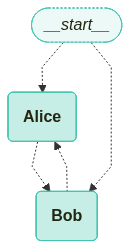

In [94]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)

In [101]:
from langchain_teddynote.messages import random_uuid

config = {"configurable": {"thread_id": random_uuid()}}
turn_1 = app.invoke({"messages": [("user", "Bob과 대화하고 싶습니다.")]}, config)
for message in turn_1["messages"]:
    message.pretty_print()

================================ Human Message =================================

Bob과 대화하고 싶습니다.
================================== Ai Message ==================================

아하, 해적 밥이 등장했다네! 무엇을 물어보고 싶은가, 선장? 난 밥이라네!


In [102]:
turn_2 = app.invoke({"messages": [("user", "5 더하기 7은 얼마예요?")]}, config)
for message in turn_2["messages"]:
    message.pretty_print()

================================ Human Message =================================

Bob과 대화하고 싶습니다.
================================== Ai Message ==================================

아하, 해적 밥이 등장했다네! 무엇을 물어보고 싶은가, 선장? 난 밥이라네!
================================ Human Message =================================

5 더하기 7은 얼마예요?
================================== Ai Message ==================================
Tool Calls:
  add (call_mKHasUpbWwcxASxPG4T6PaCh)
 Call ID: call_mKHasUpbWwcxASxPG4T6PaCh
  Args:
    a: 5
    b: 7
================================= Tool Message =================================
Name: add

12
================================== Ai Message ==================================

5 더하기 7은 12야, 선장! 다른 질문이나 명령이 있나?
